In [4]:

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations
#from datetime import datetime

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.experimentclasses.EthanolAngles import EthanolAngles
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell



from codes.geometer.RiemannianManifold import RiemannianManifold
from codes.geometer.ShapeSpace import ShapeSpace
from codes.geometer.TangentBundle import TangentBundle


def get_grads(experiment, Mpca, Mangles, N, selected_points):
    dimnoise = experiment.dimnoise
    dim = experiment.dim
    cores = experiment.cores

    tangent_bases = Mpca.get_wlpca_tangent_sel(Mpca, selected_points, dimnoise)
    subM = RiemannianManifold(Mpca.data[selected_points], dim)
    subM.tb = TangentBundle(subM, tangent_bases)
    N.tangent_bundle = TangentBundle(N, np.swapaxes(N.geom.rmetric.Hvv[:,:dim,:],1,2))

    df_M = experiment.get_dF_js_idM(Mpca, N, subM.tb, N.tangent_bundle, selected_points, dimnoise)
    
    n = len(selected_points)
    df_M2 = df_M / ((1/n)*np.sum(np.linalg.norm(df_M, axis=1) ** 2, axis=0)**(0.5))
    dg_x = experiment.get_dx_g_full(Mangles.data[selected_points])

    W = ShapeSpace(experiment.positions, Mangles.data)
    dw = W.get_dw(cores, experiment.atoms3, experiment.natoms, selected_points)
    dg_w = experiment.project(np.swapaxes(dw, 1, 2),
                              experiment.project(dw, dg_x))

    dg_w_pca = np.asarray([np.matmul(experiment.projector, dg_w[j].transpose()).transpose() for j in range(len(selected_points))])
    dgw_norm = experiment.normalize(dg_w_pca)
    dg_M = experiment.project(subM.tb.tangent_bases, dgw_norm)
    return (df_M2, dg_M, dg_w, dg_w_pca, dgw_norm,tangent_bases)


#set parameters

#set parameters
n = 50000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 1. #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#these are just for loading... probably not necessary
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

#folder = workingdirectory + '/Figures/malonaldehyde/' + now + 'n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(nreps)
#os.mkdir(folder)

#src = workingdirectory + '/codes/experiments/malonaldehyde_110120_nsel100_nreps25.py'
#filenamescript = folder + '/script.py'
#copyfile(src, filenamescript)

new_MN = True
new_grad = True
data_wd = '/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/'

new_MN = True
new_grad = True
if new_MN == True:
    experiment = EthanolAngles(dim,  ii, jj,cores,atoms4)
    projector  = np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50_components.npy')
    experiment.M = experiment.load_data(workingdirectory = data_wd)  # if noise == False then noise parameters are overriden
    experiment.Mpca = RiemannianManifold(np.load(data_wd + '/untracked_data/chemistry_data/ethanolangles022119_pca50.npy'), dim)
    experiment.q = m
    experiment.m = m
    experiment.dimnoise = dimnoise
    experiment.projector = projector
    experiment.Mpca.geom = experiment.Mpca.compute_geom(diffusion_time, n_neighbors)
    experiment.N = experiment.Mpca.get_embedding3(experiment.Mpca.geom, m, diffusion_time, dim)
    
    
natoms = 9
tol = 1e-14
atoms4,p = get_all_atoms_4(natoms)
experiment.p = p
experiment.atoms4 = atoms4
#experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
#experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))


In [5]:
nreps = 1

In [6]:
natoms = 9
tol = 1e-14
atoms4,p = get_all_atoms_4(natoms)
experiment.p = p
experiment.atoms4 = atoms4
#experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
#experiment.folder = folder

 #replicates[i].dg_M = np.swapaxes(replicates[i].dg_M,1,2)


NameError: name 'folder' is not defined

In [7]:
replicates = {}
selected_points_save = np.zeros((nreps,nsel))

print('pre-gradient acquisition')
print(datetime.datetime.now())
for i in range(nreps):
    print(i)
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm, replicates[i].tangent_bases  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    replicates[i].dg_M = np.swapaxes(replicates[i].dg_M, 1,2)
    #replicates[i].df_M = replicates[i].tangent_bases
   

pre-gradient acquisition
2021-02-05 13:37:08.574469
0


In [25]:
0.0005 * np.sqrt(756 * 100)

0.1374772708486752

In [26]:
0.0005 * 756 * 10000

3780.0

In [70]:
#.3423 gives 546
r = 0 
GGL = GradientGroupLasso(replicates[r].dg_M, replicates[r].df_M, np.asarray([1]), np.asarray([0.]), 500,.5, 1e-14, beta0_npm= None)
GGL.fit()
np.where(np.linalg.norm(GGL.fit_[0]['beta'], axis = tuple([0,2])) !=0)[0]

0
lr 0.5
lr 0.25
lr 0.125
lr 0.0625
lr 0.03125
lr 0.015625
lr 0.0078125
lr 0.00390625
lr 0.001953125
lr 0.0009765625
lr 0.00048828125
lr 0.000244140625
lr 0.0001220703125
lr 6.103515625e-05
1
lr 6.103515625e-05
2
lr 6.103515625e-05
lr 3.0517578125e-05
3
lr 3.0517578125e-05
4
lr 3.0517578125e-05
5
lr 3.0517578125e-05
6
lr 3.0517578125e-05
7
lr 3.0517578125e-05
8
lr 3.0517578125e-05
9
lr 3.0517578125e-05
10
lr 3.0517578125e-05
11
lr 3.0517578125e-05
12
lr 3.0517578125e-05
13
lr 3.0517578125e-05
14
lr 3.0517578125e-05
15
lr 3.0517578125e-05
16
lr 3.0517578125e-05
17
lr 3.0517578125e-05
18
lr 3.0517578125e-05
19
lr 3.0517578125e-05
20
lr 3.0517578125e-05
21
lr 3.0517578125e-05
22
lr 3.0517578125e-05
23
lr 3.0517578125e-05
24
lr 3.0517578125e-05
25
lr 3.0517578125e-05
26
lr 3.0517578125e-05
27
lr 3.0517578125e-05
28
lr 3.0517578125e-05
29
lr 3.0517578125e-05
30
lr 3.0517578125e-05
31
lr 3.0517578125e-05
32
lr 3.0517578125e-05
33
lr 3.0517578125e-05
34
lr 3.0517578125e-05
35
lr 3.0517578125e

lr 3.0517578125e-05
340
lr 3.0517578125e-05
341
lr 3.0517578125e-05
342
lr 3.0517578125e-05
343
lr 3.0517578125e-05
344
lr 3.0517578125e-05
345
lr 3.0517578125e-05
346
lr 3.0517578125e-05
347
lr 3.0517578125e-05
348
lr 3.0517578125e-05
349
lr 3.0517578125e-05
350
lr 3.0517578125e-05
351
lr 3.0517578125e-05
352
lr 3.0517578125e-05
353
lr 3.0517578125e-05
354
lr 3.0517578125e-05
355
lr 3.0517578125e-05
356
lr 3.0517578125e-05
357
lr 3.0517578125e-05
358
lr 3.0517578125e-05
359
lr 3.0517578125e-05
360
lr 3.0517578125e-05
361
lr 3.0517578125e-05
362
lr 3.0517578125e-05
363
lr 3.0517578125e-05
364
lr 3.0517578125e-05
365
lr 3.0517578125e-05
366
lr 3.0517578125e-05
367
lr 3.0517578125e-05
368
lr 3.0517578125e-05
369
lr 3.0517578125e-05
370
lr 3.0517578125e-05
371
lr 3.0517578125e-05
372
lr 3.0517578125e-05
373
lr 3.0517578125e-05
374
lr 3.0517578125e-05
375
lr 3.0517578125e-05
376
lr 3.0517578125e-05
377
lr 3.0517578125e-05
378
lr 3.0517578125e-05
379
lr 3.0517578125e-05
380
lr 3.0517578125e

array([ 14,  16,  17,  20,  26,  30,  31,  32,  33,  34,  35,  50,  56,
        68,  74,  80, 102, 103, 104, 105, 106, 115, 116, 121, 122, 150,
       151, 152, 153, 154, 155, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 189, 191, 192, 193, 194, 195, 196,
       197, 198, 199, 201, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 240, 241, 243, 245, 246, 247, 249, 251, 258,
       259, 261, 263, 276, 277, 279, 281, 282, 283, 285, 287, 294, 295,
       297, 298, 299, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327,
       328, 329, 330, 331, 332, 333, 334, 343, 344, 345, 346, 349, 350,
       351, 352, 355, 356, 358, 360, 361, 362, 363, 364, 365, 367, 368,
       369, 370, 373, 374, 375, 376, 377, 379, 380, 381, 382, 384, 385,
       386, 387, 388, 389, 402, 403, 404, 406, 407, 414, 416, 418, 419,
       420, 422, 424, 425, 427, 428, 429, 430, 433, 434, 435, 436, 438,
       439, 440, 441, 442, 444, 462, 463, 464, 466, 467, 474, 47

In [73]:
np.where(np.linalg.norm(GGL.fit_[0]['beta'], axis = tuple([0,2])) !=0)[0].shape

(345,)

In [15]:
r = 0 
ul = np.linalg.norm(np.einsum('n d m, n d p -> n p m ' ,replicates[r].df_M , replicates[r].dg_M), axis = tuple([0,2])).max()

In [18]:
replicates[r].dg_M.shape

(100, 2, 756)

In [17]:
ul

1098.2982723719172

In [55]:
selected_points_save = np.asarray(selected_points_save, dtype = int)
gl_itermax = 500
lambdas_start = [0.,ul]
max_search = 30
reg_l2 = 0.
card = dim
tol = 1e-14
learning_rate = 100

from pathos.multiprocessing import ProcessingPool as Pool
from codes.flasso.GradientGroupLasso import batch_stream, get_sr_lambda_sam_parallel

print('pre-gradient descent')
print(datetime.datetime.now())
cores = 16
pcor = Pool(cores)
results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate),
                batch_stream(replicates))


pre-gradient descent
2021-02-05 14:42:23.596737


In [64]:
#reorder lambdas and coefficients
nreps = 1
for r in range(nreps):
    cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
    xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
    xaxis_reorder = xaxis[xaxis.argsort()]
    cs_reorder = cs[xaxis.argsort()]
    xaxis_reorder = xaxis[xaxis.argsort()]
    replicates[r].cs = cs
    replicates[r].cs_reorder = cs_reorder
    replicates[r].xaxis_reorder = xaxis_reorder
    replicates[r].xaxis = xaxis


#get selection lambda
sel_l = np.zeros(nreps, dtype = int)
for r in range(nreps):
    for l in range(replicates[r].cs_reorder.shape[0]):
        zeros = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[l] !=0.)[0]
        if len(zeros) == 2:
            sel_l[r] = l
            #print(np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[2] !=0.))


#get almost selection lambda
almost_sel = {}
sel = {}
min_sel = {}
for r in range(nreps):
    print('s')
    almost_sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]-1] !=0.)[0]
    sel[r] = np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[sel_l[r]] !=0.)[0]
    print('a')
    min_sel[r] =  np.where((replicates[r].cs_reorder**2).sum(axis = 1).sum(axis = 1)[0] !=0.)[0]
#sel_total = almost_sel

#subset

subset = np.unique(np.hstack([np.concatenate(list(almost_sel.values())),np.concatenate(list(sel.values())) ]))
psmallest = len(subset)

to_plot = np.zeros((psmallest, psmallest))

for r in range(nreps):
    i_smallest = np.where(subset == sel[r][0])[0]
    j_smallest = np.where(subset == sel[r][1])[0]
    to_plot[i_smallest,j_smallest] +=1
    to_plot[j_smallest,i_smallest] +=1
    
names = np.zeros(len(subset), dtype = object)
for s in range(len(subset)):
    names[s] = r"$g_{{{}}}$".format(subset[s])

cmap = plt.get_cmap('brg',len(subset))

colors_subset = np.zeros((len(subset),4))
for s in range(len(subset)):
    colors_subset[s] = cmap(s)

subset_l0 = np.unique(np.asarray(list(sel.values())))
psmallest = len(subset_l0)
to_plot_l0 = np.zeros((psmallest, psmallest))


for r in range(nreps):
    #to_plot[sel]
    
    i_smallest = np.where(subset_l0 == sel[r][0])[0]
    print(sel[r][0], i_smallest)
    
    j_smallest = np.where(subset_l0 == sel[r][1])[0]
    print(sel[r][0], j_smallest)
    
    to_plot_l0[i_smallest,j_smallest] +=1
    to_plot_l0[j_smallest,i_smallest] +=1
    
names_l0 = np.zeros(len(subset_l0), dtype = object)
for s in range(len(subset_l0)):
    names_l0[s] = r"$g_{{{}}}$".format(subset_l0[s])

names = np.zeros(len(subset), dtype = object)
for s in range(len(subset)):
    names[s] = r"$g_{{{}}}$".format(subset[s])



s
a
721 [0]
721 [1]


In [65]:
r= 0
colors = np.zeros((756,4))
colors[:,3] = 1

#colors[r0subset] = colors_r0
colors[subset] = colors_subset

cs = rearrange(np.asarray(list(results[r][1].values())), 'l n p m -> l m n p')
xaxis = np.asarray(np.asarray(list(results[r][1].keys())))
xaxis_reorder = xaxis[xaxis.argsort()]
cs_reorder = cs[xaxis.argsort()]
xaxis_reorder = xaxis[xaxis.argsort()]
replicates[r].cs = cs
replicates[r].cs_reorder = cs_reorder
replicates[r].xaxis_reorder = xaxis_reorder
replicates[r].xaxis = xaxis


In [67]:
min_sel[0].shape

(756,)

In [58]:
%matplotlib inline

In [59]:
sell_plot = np.where(xaxis_reorder == results[r][0])[0]

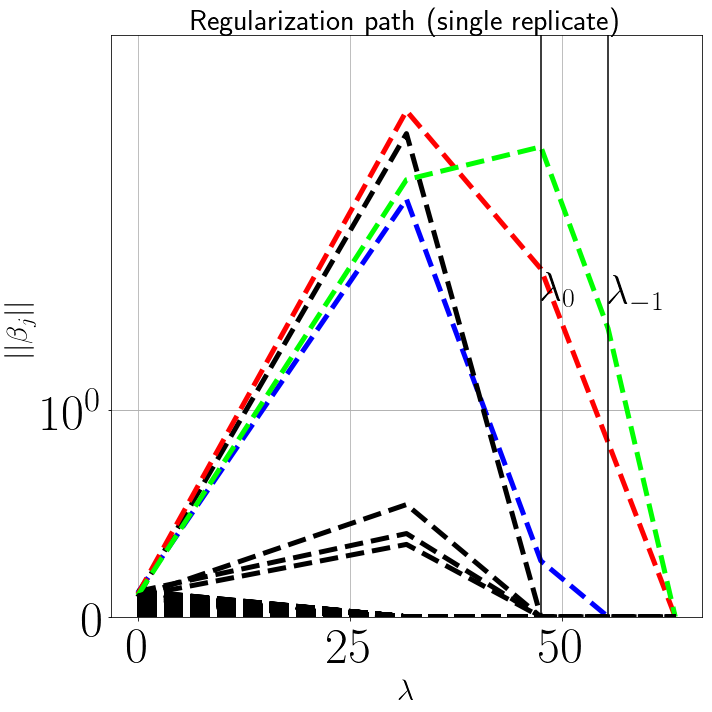

In [60]:
f, axarr = plt.subplots(1,1,figsize=(10, 10))
#axarr.set_axis_off() 
#mpl.style.use('default')
plot_reg_path_ax_lambdasearch_customcolors_norm(axarr, cs_reorder, xaxis_reorder / np.sqrt(nsel * m ) , f,colors)#axes_all[0].imshow(asdf)
axarr.set_xlabel(r'$\lambda$', fontsize = 30)
axarr.set_ylabel(r'$||\beta_j||$', fontsize = 30)

axarr.axvline(xaxis_reorder[sell_plot] / np.sqrt(nsel * m )  , color = 'black')
axarr.text(xaxis_reorder[sell_plot] / np.sqrt(nsel * m ) , 1.5, r'$\lambda_{-1}$', fontsize = 40)
axarr.axvline(xaxis_reorder[sell_plot-1]/ np.sqrt(nsel * m )  , color = 'black')
axarr.text(xaxis_reorder[sell_plot-1]/ np.sqrt(nsel * m )  , 1.5, r'$\lambda_{0}$', fontsize = 40)
axarr.set_title('Regularization path (single replicate)')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/eth_fulldict_replicate')

#axarr.patch.set_facecolor('None')

In [8]:
from einops import rearrange

import autograd.numpy as np
from autograd import jacobian
from autograd import elementwise_grad
from autograd import grad

import logging
from copy import deepcopy

#import numpy as np
from scipy.special import expit
from pyglmnet import utils


class GradientGroupLasso:
    
    def __init__(self, dg_M, df_M, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None):
        
        n = dg_M.shape[0]
        d= dg_M.shape[1]
        m = df_M.shape[2]
        p = dg_M.shape[2]
        dummy_beta = np.ones((n,p,m))
        
        self.dg_M = dg_M
        self.df_M = df_M
        self.reg_l1s = reg_l1s
        self.reg_l2 = reg_l2
        self.beta0_npm = beta0_npm
        self.n = n
        self.p = p
        self.m = m 
        self.d = d
        self.dummy_beta = dummy_beta
        #self.group = np.asarray(group)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.Tau = None
        self.alpha = 1.
        self.lossresults = {}
        self.dls = {}
        self.l2loss = {}
        self.penalty = {}
        
    def _prox(self,beta_npm, thresh):
        """Proximal operator."""
        
        p = self.p
        result = np.zeros(beta_npm.shape)
        result = np.asarray(result, dtype = float)
        for j in range(p):
            if np.linalg.norm(beta_npm[:,j,:]) > 0.:
                potentialoutput = beta_npm[:,j,:] - (thresh / np.linalg.norm(beta_npm[:,j,:])) * beta_npm[:,j,:]
                posind = np.asarray(np.where(beta_npm[:,j,:] > 0.))
                negind = np.asarray(np.where(beta_npm[:,j,:] < 0.))
                po = beta_npm[:,j,:].copy()
                po[posind[0],posind[1]] = np.asarray(np.clip(potentialoutput[posind[0],posind[1]],a_min = 0., a_max = 1e15), dtype = float)
                po[negind[0],negind[1]] = np.asarray(np.clip(potentialoutput[negind[0],negind[1]],a_min = -1e15, a_max = 0.), dtype = float)
                result[:,j,:] = po
        return result

    def _grad_L2loss(self, beta_npm):
        
        df_M = self.df_M
        dg_M = self.dg_M
        reg_l2 = self.reg_l2
        dummy_beta = self.dummy_beta
        
        df_M_hat = np.einsum('ndp,npm->ndm',dg_M, beta_npm)
        error = df_M_hat - df_M
        grad_beta = np.einsum('ndm,ndp->npm',error,dg_M) #+ reg_l2 * np.ones()
        #if 
        return grad_beta
    
    def _L1penalty(self, beta_npm):
        
        p = self.p
        m = self.m
        n = self.n 
        beta_mn_p = rearrange(beta_npm, 'n p m -> (m n) p')#np.reshape(beta_mnp, ((m*n,p)))
        L1penalty = np.linalg.norm(beta_mn_p, axis = 0).sum()
        
        return L1penalty
    
    def _loss(self,beta_npm, reg_lambda):
        """Define the objective function for elastic net."""
        L = self._logL(beta_npm)
        P = self._L1penalty(beta_npm)
        J = -L + reg_lambda * P
        return J
    
    def _logL(self,beta_npm):
        
        df_M = self.df_M
        dg_M = self.dg_M
        
        df_M_hat = np.einsum('ndp,npm -> ndm',dg_M, beta_npm)
        logL = -0.5 * np.linalg.norm((df_M - df_M_hat))**2
        return(logL)
    
    def _L2loss(self,beta_npm):
        output = -self._logL(beta_npm)
        return(output)

    def fhatlambda(self,learning_rate,beta_npm_new,beta_npm_old):

        print('lr',learning_rate)
        output = self._L2loss(beta_npm_old) + np.einsum('npm,npm', self._grad_L2loss(beta_npm_old),(beta_npm_new-beta_npm_old)) + (1/(2*learning_rate)) * np.linalg.norm(beta_npm_new-beta_npm_old)**2
        
        return(output)

    def _btalgorithm(self,beta_npm ,learning_rate,b,maxiter_bt,rl):
        
        grad_beta = self._grad_L2loss(beta_npm = beta_npm)
        for i in range(maxiter_bt):
            beta_npm_postgrad = beta_npm - learning_rate * grad_beta
            beta_npm_postgrad_postprox = self._prox(beta_npm_postgrad, learning_rate * rl)
            fz = self._L2loss(beta_npm_postgrad_postprox)
            #fhatz = self.fhatlambda(lam,beta_npm_postgrad_postprox, beta_npm_postgrad)
            fhatz = self.fhatlambda(learning_rate,beta_npm_postgrad_postprox, beta_npm)
            if fz <= fhatz:
                #print(i)
                break
            learning_rate = b*learning_rate    
            
        return(beta_npm_postgrad_postprox,learning_rate)
    
    def fit(self, beta0_npm = None):

        reg_l1s = self.reg_l1s
        n = self.n
        m = self.m
        p = self.p
        
        dg_M = self.dg_M
        df_M = self.df_M
        
        tol = self.tol
        np.random.RandomState(0)
        
        if beta0_npm is None:
            beta_npm_hat = 1 / (n*m*p) * np.random.normal(0.0, 1.0, [n, p,m])
            #1 / (n_features) * np.random.normal(0.0, 1.0, [n_features, n_classes])
        else: 
            beta_npm_hat = beta0_npm
            
        fit_params = list()
        for l, rl in enumerate(reg_l1s):
            fit_params.append({'beta': beta_npm_hat})
            if l == 0:
                fit_params[-1]['beta'] = beta_npm_hat
            else:
                fit_params[-1]['beta'] = fit_params[-2]['beta']
            
            alpha = 1.
            beta_npm_hat = fit_params[-1]['beta']
            #g = np.zeros([n_features, n_classes])
            L, DL ,L2,PEN = list(), list() , list(), list()
            learning_rate = self.learning_rate
            beta_npm_hat_1 = beta_npm_hat.copy()
            beta_npm_hat_2 = beta_npm_hat.copy()
            for t in range(0, self.max_iter):
                #print(t,l,rl)
                print(t)
                L.append(self._loss(beta_npm_hat, rl))
                L2.append(self._L2loss(beta_npm_hat))
                PEN.append(self._L1penalty(beta_npm_hat))
                w = (t / (t+ 3))
                beta_npm_hat_momentumguess = beta_npm_hat + w*(beta_npm_hat_1 - beta_npm_hat_2)
                
                beta_npm_hat , learning_rate = self._btalgorithm(beta_npm_hat_momentumguess,learning_rate,.5,1000, rl)
                #print(beta_npm_hat_momentumguess.max(), beta_npm_hat.max(),self._L2loss(beta_npm_hat), learning_rate)
                beta_npm_hat_2 = beta_npm_hat_1.copy()
                beta_npm_hat_1 = beta_npm_hat.copy()
                
                if t > 1:
                    DL.append(L[-1] - L[-2])
                    if np.abs(DL[-1] / L[-1]) < tol:
                        print('converged', rl)
                        msg = ('\tConverged. Loss function:'
                               ' {0:.2f}').format(L[-1])
                        msg = ('\tdL/L: {0:.6f}\n'.format(DL[-1] / L[-1]))
                        break

            fit_params[-1]['beta'] = beta_npm_hat
            self.lossresults[rl] = L
            self.l2loss[rl] = L2
            self.penalty[rl] = PEN
            self.dls[rl] = DL

        self.fit_ = fit_params
        #self.ynull_ = np.mean(y)

        return self

In [48]:

def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    #for k in range(1 + q):
    ax.tick_params(labelsize=50)
    #ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=0, top=normax)
    # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
    #if (k == 0):
    tixx = np.hstack(
        [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
#    if k != 0:
        # axes[k].set_yticks(tixx)
    #ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
    #ax.set_xlabel(r"$\lambda  \sqrt{nm}$", fontsize = 70)
    #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    #ax.l
    #if k == 0:
    #ax.set_title("Combined", fontdict={'fontsize': 50})
    ax.grid(True, which="both", alpha=True)

def plot_watch3(to_plot, names, colors,ax):
    
    p = to_plot.shape[0]
    #fig, ax = plt.subplots(figsize = (15,15))
    #%matplotlib inline
    
    #fig, ax = plt.subplots(figsize = (15,15))
    theta = np.linspace(0, 2*np.pi, 10000)
    #cmap = plt.get_cmap('twilight_shifted',p)
    
    angles = np.linspace(0, 2*np.pi, p+1)
    
    radius = 1.

    a = radius*np.cos(theta)
    b = radius*np.sin(theta)

    #figure, axes = plt.subplots(figsize = (15,15))

    #axes.plot(a, b, color= 'gray')
    ax.scatter(a, b, color = 'gray', s= .2, alpha = .1)#, '-', color = 'gray')#, s= .1, alpha = .1)#, type = 'line')#,cmap=plt.get_cmap('twilight')) #'hsv','twilight_shifted

    #for i in range(to_plot.shape)
    if len(to_plot.shape) > 1:
        totes = np.sum(to_plot, axis = 0)
    else:
        totes = to_plot
        
    for j in range(p):
        print(np.cos(angles[j]), np.sin(angles[j]))#r'$test \frac{1}{}$'.format(g)
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'x')
        ax.text( x = 1.1*np.cos(angles[j]),
                  y = 1.1*np.sin(angles[j]),
                  s = names[j],color=colors[j],
                  fontdict = {'fontsize' : 40},
                  horizontalalignment='center',
         verticalalignment='center')

        ax.text( x = .9*np.cos(angles[j]),y = .9*np.sin(angles[j]),s = str(totes[j] / nreps), fontdict = {'fontsize' : 30},
                  horizontalalignment='center',
         verticalalignment='center')



    for j in range(p):
        ax.scatter(np.cos(angles[j]),np.sin(angles[j]),color=colors[j], marker  = 'o', s = 100*totes[j] )

    if len(to_plot.shape) > 1:
        for i in range(p):
            for j in range(p):

                #point1 = [1, 2]
                #point2 = [3, 4]

                x_values = [np.cos(angles[j]), np.cos(angles[i])]
                #gather x-values

                y_values = [np.sin(angles[j]), np.sin(angles[i])]
                #gather y-values

                ax.plot(x_values, y_values,linewidth = to_plot[i,j], color = 'black')

                if to_plot[i,j] > 0 :
                    ax.text(x = np.mean(x_values),
                      y = np.mean(y_values),
                      s = str(to_plot[i,j] / nreps),
                      fontdict = {'fontsize' : 20})#,
                  #horizontalalignment='left',
                # verticalalignment='bottom')
                #axes.axline((x1, y1), (x2, y2))
    ax.set_aspect(1)
    ax.set_axis_off()

def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

def get_kappa_s(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    kappa_i = np.max(kappa_ij, axis = 1) / np.min(kappa_ij, axis = 1)
    kappa = np.max(kappa_i)    
    return(kappa)

def get_coses_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def get_mu_full_ind(dg, ind):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    l = len(ind)
    coses = np.zeros((n, l, p))
    for i in range(n):
        #print(i)
        for j in range(l):
            for k in range(p):
                if ind[j] != k:
                    coses[i, j, k] = cosine_similarity(dg[i, ind[j], :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses.max())

def get_min_min(dg_M):
    n = dg_M.shape[0]
    d= dg_M.shape[1]
    p = dg_M.shape[2]
    maxes = np.zeros(n)
    #coses_zerodiag = coses.copy()
    kappa_ij= np.zeros((n,p))
    for i in range(n):
        kappa_ij[i] = np.linalg.norm(dg_M[i], axis = 0)
    min_min = np.min(kappa_ij)
    return(min_min)

def get_gamma_max(dg_M):
    output = np.sum(np.sum(dg_M**2, axis = 1), axis = 0).max()
    return(output)

# def get_cosines(self, dg):
def get_cosines_full(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]
    coses = np.zeros((n, p, p))
    for i in range(n):
        #print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)

def cosine_similarity(a, b):
    output = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return (output)

# def get_cosines(self, dg):
def get_cosines2(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    #cos_summary = np.sum(coses ** 2, axis=0) / n
    return (coses)
#coses = get_cosines2(np.swapaxes(replicates[0].dg_M,1,2))

def get_cosines(dg):
    n = dg.shape[0]
    p = dg.shape[1]
    d = dg.shape[2]

    coses = np.zeros((n, p, p))
    for i in range(n):
        print(i)
        for j in range(p):
            for k in range(p):
                coses[i, j, k] = cosine_similarity(dg[i, j, :], dg[i, k,:])  # sklearn.metrics.pairwise.cosine_similarity(X = np.reshape(dg[:,i,:], (1,d*n)),Y = np.reshape(dg[:,j,:], (1,d*n)))[0][0]
    # cos_summary = np.abs(coses).sum(axis = 0) / n
    cos_summary = np.mean(coses, axis = 0)#np.sum(coses ** 2, axis=0) / n
    return (cos_summary)